In [1]:
#setting up google co-lab and scvi-tools
!pip install --quiet scvi-colab
from scvi_colab import install
install() 

     |████████████████████████████████| 235 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import anndata
import pandas as pd
from scipy.sparse import hstack

#import helper function
import sys
sys.path.insert(0, 'drive/MyDrive/work/single_cell_analysis_demo/src/')
from util import *

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [3]:
#load the data we generated using signac_and_dataFormat_manipulation_demo.R
adata_atac = scvi.data.read_10x_multiome("drive/MyDrive/work/single_cell_analysis_demo/ccRCC_ATAC")
adata_rna = scvi.data.read_10x_multiome("drive/MyDrive/work/single_cell_analysis_demo/ccRCC_RNA")

In [4]:
#creating the pseudo paired peak-gene anndata object for this demo
adata_pair_X=hstack((adata_rna.X,adata_atac.X))
adata_pair_var=pd.concat([adata_rna.var,adata_atac.var])
adata_pair=anndata.AnnData(adata_pair_X,obs=adata_rna.obs,var=adata_pair_var)

In [5]:
#add the modality to the observations
adata_pair.obs["modality"]= "paired"
adata_atac.obs["modality"]= "peaks"
adata_rna.obs["modality"]= "expression"

In [6]:
#set up the multiome and MultiVI training anndata structure
adata_mvi = scvi.data.organize_multiome_anndatas(adata_pair,
                                                 rna_anndata=adata_rna,
                                                 atac_anndata=adata_atac,
                                                 modality_key='modality')

scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

In [7]:
#define the training model
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_pair.var['modality']=='expression').sum(),
    n_regions=(adata_pair.var['modality']=='peaks').sum(),
)

In [8]:
#double check the setup 
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│          n_vars          │ 140301 │
│         n_cells          │ 25068  │
│         n_batch          │   3    │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │         adata.X          │
│    batch     │ adata.obs['_scvi_batch'] │
└──────────────┴──────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

In [9]:
#train the MultiVI model
mvi.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:386: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/500:   0%|          | 1/500 [00:34<4:48:06, 34.64s/it, loss=1.08e+04, v_num=1]

In [ ]:
#save trained model
#mvi.save("drive/MyDrive/work/single_cell_analysis_demo/trained_ccRCC_multivi")

In [10]:
#load the trained model
mvi = scvi.model.MULTIVI.load(
    "drive/MyDrive/work/single_cell_analysis_demo/trained_ccRCC_multivi", adata=adata_mvi)

INFO     File drive/MyDrive/work/single_cell_analysis_demo/trained_ccRCC_multivi/model.pt    
         already downloaded                                                                  


In [12]:
#load the latent representation
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()

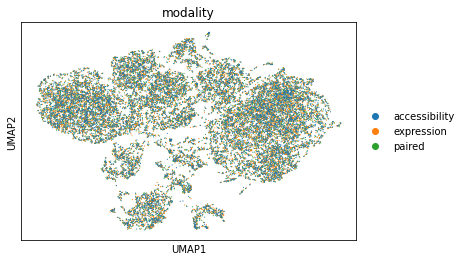

In [130]:
#visualization
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi)
sc.pl.umap(adata_mvi, color='modality')

In [116]:
#start to annotate the cell types in this integrate dataset
#marker genes
marker_genes = ["SLC34A1","LRP2","CFH","SLC12A1","EMCN","ACTA2","SLC5A2","SLC5A1",
                "SLC12A3","SLC26A7","SLC26A4","NPHS2","PTPRC","HAVCR1","AQP2"]
#cell type marker gene subsets
#extract from Fig 1F, doi.org/10.1038/s41467-021-22368-w 
pt_geneset = {"positive":["SLC34A1"],
              "negative":["EMCN"]}

PEC_geneset = {"positive":["CFH"],
              "negative":[]}

TAL_geneset = {"positive":["SLC12A1"],
              "negative":[]}

DCT_geneset = {"positive":["SLC12A3"],
              "negative":[]}

PC_geneset = {"positive":["AQP2"],
              "negative":[]}

ICA_geneset = {"positive":["SLC26A7"],
              "negative":[]}

ICB_geneset = {"positive":["SLC26A4"],
              "negative":[]}

PODO_geneset = {"positive":["NPHS2"],
              "negative":[]}

ENDO_geneset = {"positive":["EMCN"],
              "negative":[]}

MF_geneset = {"positive":["ACTA2"],
              "negative":[]}

LEUK_geneset = {"positive":["PTPRC"],
              "negative":[]}

In [117]:
#make a normalized copy of the dataset
normalized = adata_mvi.copy()
sc.pp.normalize_total(normalized, target_sum = 1e4)
sc.pp.log1p(normalized)

In [118]:
#select the marker genes
normalized = normalized[:,marker_genes].copy()
sc.pp.scale(normalized)

In [119]:
#annotate the seed cells using the marker genes
pt_cell   = get_cell_mask(normalized, pt_geneset,)
PEC_cell  = get_cell_mask(normalized, PEC_geneset,)
TAL_cell  = get_cell_mask(normalized, TAL_geneset,)
DCT_cell  = get_cell_mask(normalized, DCT_geneset,)
PC_cell   = get_cell_mask(normalized, PC_geneset,)
ICA_cell  = get_cell_mask(normalized, ICA_geneset,)
ICB_cell  = get_cell_mask(normalized, ICB_geneset,)
PODO_cell = get_cell_mask(normalized, PODO_geneset,)
ENDO_cell = get_cell_mask(normalized, ENDO_geneset,)
MF_cell   = get_cell_mask(normalized, MF_geneset,)
LEUK_cell = get_cell_mask(normalized, LEUK_geneset,)

seed_labels = np.array(PODO_cell.shape[0] * ["Unknown"])
seed_labels[pt_cell]   = "PT"
seed_labels[PEC_cell]  = "PEC"
seed_labels[TAL_cell]  = "TAL"
seed_labels[DCT_cell]  = "DCT"
seed_labels[PC_cell]   = "PC"
seed_labels[ICA_cell]  = "ICA"
seed_labels[ICB_cell]  = "ICB"
seed_labels[PODO_cell] = "PODO"
seed_labels[ENDO_cell] = "ENDO"
seed_labels[MF_cell]   = "MES_FIB"
seed_labels[LEUK_cell] = "LEUK"
adata_mvi.obs["seed_labels"] = seed_labels

In [120]:
#double check the seed cells defined
adata_mvi.obs.seed_labels.value_counts()

Unknown    24562
LEUK          50
MES_FIB       49
PC            48
PODO          48
ENDO          48
ICA           47
ICB           47
DCT           47
PT            45
TAL           40
PEC           37
Name: seed_labels, dtype: int64

In [121]:
#define and train a scvi model as the input for scANVI 
scvi.model.SCVI.setup_anndata(adata_mvi, batch_key="modality", labels_key="seed_labels")
scvi_model = scvi.model.SCVI(adata_mvi, n_latent=30, n_layers=2)

In [122]:
#train the scVI model
scvi_model.train(50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [11:22<00:00, 13.64s/it, loss=2.42e+04, v_num=1]


In [123]:
#define and train the scANVI model for predicting cell labels
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                             


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|██████████| 25/25 [08:47<00:00, 21.09s/it, loss=2.4e+04, v_num=1]


In [131]:
#save the scANVI model
scanvi_model.save("drive/MyDrive/work/single_cell_analysis_demo/trained_ccRCC_scANVI")

In [124]:
#predict the cell labels
adata_mvi.obs["cell_type_scANVI"] = scanvi_model.predict(adata_mvi)
adata_mvi.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_mvi)

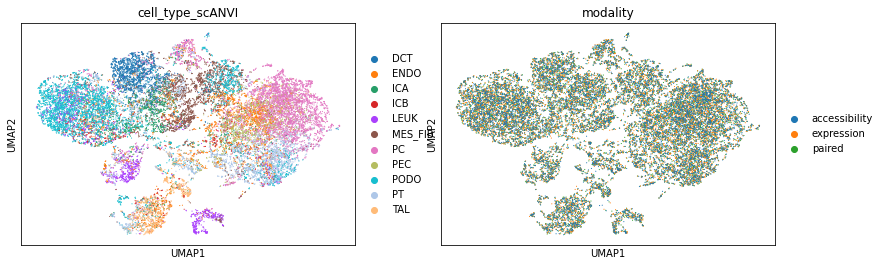

In [129]:
#plot the predicted cell type for both ATAC-seq and RNA-seq cells 
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi)
sc.pl.umap(adata_mvi, color=['cell_type_scANVI','modality']) 